In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Bidirectional, BatchNormalization, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras import regularizers
import random


In [2]:

# === Step 1: Load & Clean Data ===
def load_and_preprocess_data(file_paths):
    dfs = [pd.read_csv(fp, encoding='utf-8') for fp in file_paths]
    df = pd.concat(dfs, ignore_index=True)

    for col in df.columns[:-1]:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df.dropna(inplace=True)

    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].astype(str).values
    return X, y


In [3]:

# === Step 2: Scale and Encode ===
def scale_and_encode(X, y, fit=False, scaler=None, label_encoder=None, one_hot_encoder=None):
    if fit:
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)

        label_encoder = LabelEncoder()
        y_int = label_encoder.fit_transform(y)

        one_hot_encoder = OneHotEncoder(sparse_output=False)
        y_encoded = one_hot_encoder.fit_transform(y_int.reshape(-1, 1))
    else:
        X = scaler.transform(X)
        y_int = label_encoder.transform(y)
        y_encoded = one_hot_encoder.transform(y_int.reshape(-1, 1))

    X = X.reshape((X.shape[0], 1, X.shape[1]))  # RNN expects 3D input
    return X, y_encoded, scaler, label_encoder, one_hot_encoder


In [4]:

# === Step 3: Build RNN Model ===
def build_rnn_model(input_shape, num_classes):
    model = Sequential([
        Bidirectional(LSTM(64, activation='tanh', return_sequences=True), input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.5),

        LSTM(64, activation='tanh'),
        Dropout(0.5),

        Dense(64, activation='swish', kernel_regularizer=regularizers.l2(0.01)),
        Dense(num_classes, activation='softmax')  # Final classification layer
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    return model


In [5]:

# === Step 4: Train Model ===
def train_model(model, X_train, y_train, X_val, y_val):
    early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32,
              callbacks=[early_stop, lr_scheduler])
    return model

# === Step 5: Evaluate Model ===
def evaluate_model(model, X_test, y_test_encoded, y_test_raw, label_encoder, sample_size=5):
    y_pred_probs = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_test_classes = np.argmax(y_test_encoded, axis=1)

    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

    print(f"\n✅ Accuracy: {accuracy * 100:.2f}%")
    print(f"✅ Precision: {precision:.2f}")
    print(f"✅ Recall: {recall:.2f}")
    print(f"✅ F1 Score: {f1:.2f}")

    print("\n🔍 Random Sample Predictions:")
    indices = random.sample(range(len(y_test_raw)), min(sample_size, len(y_test_raw)))
    for i in indices:
        actual = y_test_raw[i]
        predicted = label_encoder.inverse_transform([y_pred_classes[i]])[0]
        print(f"🔹 Actual: {actual} | Predicted: {predicted}")


In [6]:

# === Main Execution ===
# Step 1: Load datasets and split into training, validation, and testing
X_train_raw, y_train_raw = load_and_preprocess_data(['Irtaza1.csv', 'Aqsa1.csv', 'Saad1.csv'])
X_val_raw, y_val_raw = load_and_preprocess_data(['Hassan1.csv', 'Numairah1.csv'])  # Use two files for validation
X_test_raw, y_test_raw = load_and_preprocess_data(['Amna1.csv'])



In [7]:

# Optionally split the training data into training and validation sets
X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(X_train_raw, y_train_raw, test_size=0.2, random_state=42)

# Step 2: Scale and Encode
X_train, y_train, scaler, label_encoder, one_hot_encoder = scale_and_encode(X_train_raw, y_train_raw, fit=True)
X_val, y_val, _, _, _ = scale_and_encode(X_val_raw, y_val_raw, fit=False, scaler=scaler, label_encoder=label_encoder, one_hot_encoder=one_hot_encoder)
X_test, y_test_encoded, _, _, _ = scale_and_encode(X_test_raw, y_test_raw, fit=False, scaler=scaler, label_encoder=label_encoder, one_hot_encoder=one_hot_encoder)


In [8]:

# Step 3: Build Model
model = build_rnn_model(input_shape=(X_train.shape[1], X_train.shape[2]), num_classes=y_train.shape[1])

# Step 4: Train Model
model = train_model(model, X_train, y_train, X_val, y_val)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 1, 128)         │       258,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 313,030 (1.19 MB)

 Trainable params: 312,774 (1.19 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.5631 - loss: 2.1044 - val_accuracy: 0.5278 - val_loss: 2.0547 - learning_rate: 0.0010
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9461 - loss: 0.9866 - val_accuracy: 0.6667 - val_loss: 1.5501 - learning_rate: 0.0010
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9851 - loss: 0.5375 - val_accuracy: 0.9139 - val_loss: 1.0868 - learning_rate: 0.0010
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9900 - loss: 0.3772 - val_accuracy: 0.9194 - val_loss: 0.7238 - learning_rate: 0.0010
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9904 - loss: 0.2861 - val_accuracy: 0.9861 - val_loss: 0.4492 - learning_rate: 0.0010
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9951 - loss: 0.2265 - val_accuracy: 0.9778 - val_loss: 0.3776 - learning_rate: 0.0010
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9946 - loss: 0.1763 - 

In [9]:

# Step 5: Evaluate Model
evaluate_model(model, X_test, y_test_encoded, y_test_raw, label_encoder)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step

✅ Accuracy: 84.50%
✅ Precision: 0.86
✅ Recall: 0.84
✅ F1 Score: 0.84

🔍 Random Sample Predictions:
🔹 Actual: وہ لڑکا ہے | Predicted: وہ لڑکا ہے
🔹 Actual: السلام علیکم | Predicted: السلام علیکم
🔹 Actual: آپ کيسے ہيں | Predicted: آپ کيسے ہيں
🔹 Actual: وہ لڑکا ہے | Predicted: وہ لڑکا ہے
🔹 Actual: وہ لڑکی ہے | Predicted: وہ لڑکی ہے


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1746 (\N{ARABIC LETTER YEH BARREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Arabic natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1729 (\N{ARABIC LETTER HEH GOAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


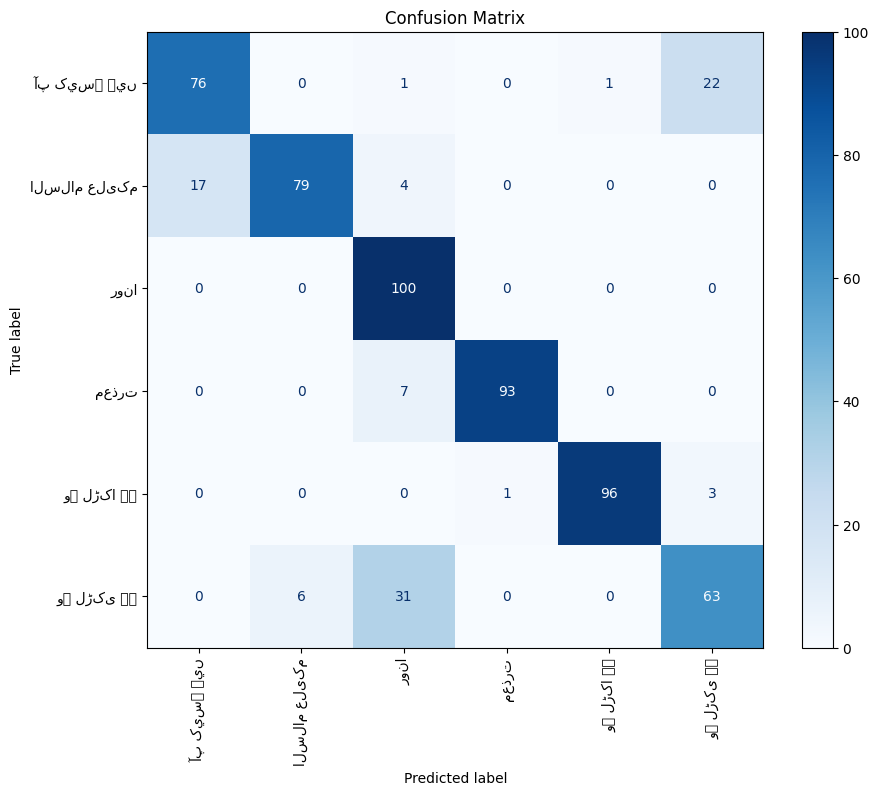

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions from the model
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_test_classes = np.argmax(y_test_encoded, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Display confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()
